In [3]:
import copy
import json
import torch
import torch.nn.utils.prune as prune
from torch.utils.data import random_split, DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
from vib_lenet_300_100_mnist import (
    VIBLeNet, train_test_split,
    batch_size, z_dim, evaluate
)
from msc import plot_x_y, get_device, load_weights
from data import MnistCsvDataset

using device: cpu


In [4]:
torch.manual_seed(42)
device = get_device()
print(f'using device: {device}')

using device: cpu


In [5]:
with open('weights/vib_lenet_300_100_mnist_beta_loss_acc_data.json', 'r') as json_file:
    data = json.load(json_file)
og_acc_list = [acc for _, acc in data['loss_acc_list']]
betas = data['betas']

print('beta v loss/acc:')
[print(f'{beta}: loss {loss:.4f}, acc {acc:.3f}%') for (loss, acc), beta in zip(data['loss_acc_list'], betas)]

beta v loss/acc:
0.5: loss 2.4895, acc 10.621%
0.4: loss 2.3273, acc 24.686%
0.3: loss 1.4655, acc 86.821%
0.2: loss 1.0803, acc 90.714%
0.1: loss 0.8659, acc 88.214%
0.05: loss 0.5351, acc 94.414%
0.01: loss 0.2645, acc 96.571%
0.005: loss 0.1962, acc 97.164%


[None, None, None, None, None, None, None, None]

In [6]:
dataset = MnistCsvDataset('data/mnist_data.csv')
train_size = int(train_test_split * len(dataset))
test_size = len(dataset) - train_size # TODO: SHOULD IT BE THE EXACT SAME SPLIT HERE?
print(f'train_size: {train_size}, test_size: {test_size}')

_, test_dataset = random_split(dataset, [train_size, test_size])
test_loader = DataLoader(test_dataset, batch_size, shuffle=True)

layer_names = ['encoder.0', 'encoder.2', 'fc_mu', 'fc_std']

train_size: 56000, test_size: 14000


100%|██████████████████████████████| 8/8 [00:01<00:00,  7.03it/s]


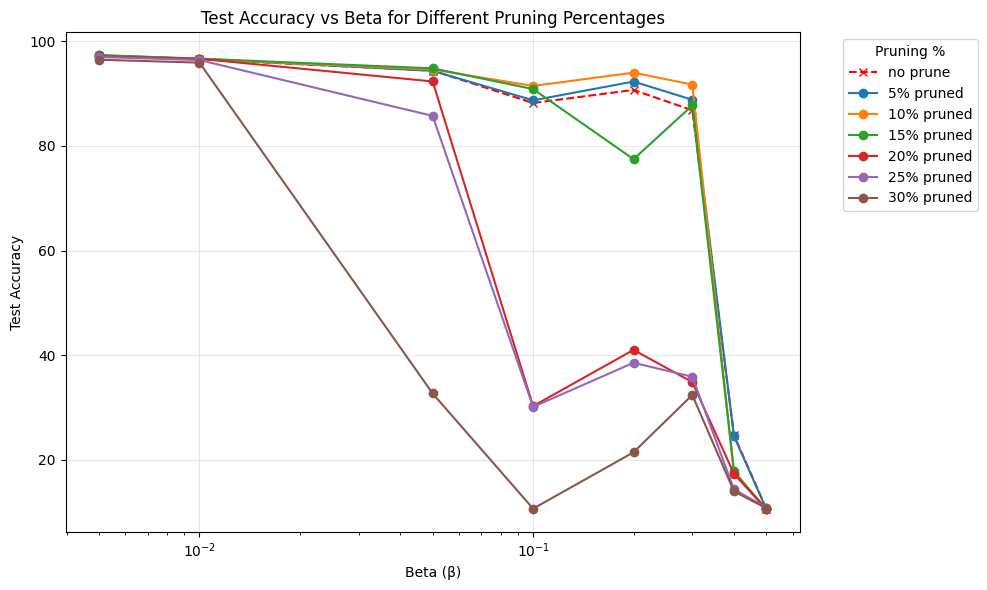

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(betas, og_acc_list, marker='x', linestyle='--', color='r', label='no prune')

prune_percs = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30]
for prune_perc in prune_percs:
    pruned_acc_list = []
    for b in tqdm(betas):
        model = VIBLeNet(z_dim=z_dim).to(device)
        weights = load_weights(f'weights/vib_lenet_300_100_mnist_{b}.pth', verbose=False)
        model.load_state_dict(weights)
        original_model = copy.deepcopy(model)

        pruned_model = copy.deepcopy(original_model)
        for layer_name in layer_names:
            module = dict(pruned_model.named_modules())[layer_name]
            prune.l1_unstructured(module, name='weight', amount=prune_perc)
        
        test_loss, test_acc = evaluate(pruned_model, test_loader, device, beta=b)
        pruned_acc_list.append(test_acc)
        
    plt.plot(betas, pruned_acc_list, label=f'{prune_perc*100:.0f}% pruned', marker='o')

plt.xscale('log')
plt.xlabel('Beta (β)')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy vs Beta for Different Pruning Percentages')
plt.legend(title='Pruning %', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('plots/vib_lenet_300_100_mnist_beta_vs_pruned_acc.png', dpi=300, bbox_inches='tight')
plt.show()

100%|██████████████████████████████| 8/8 [00:01<00:00,  6.00it/s]


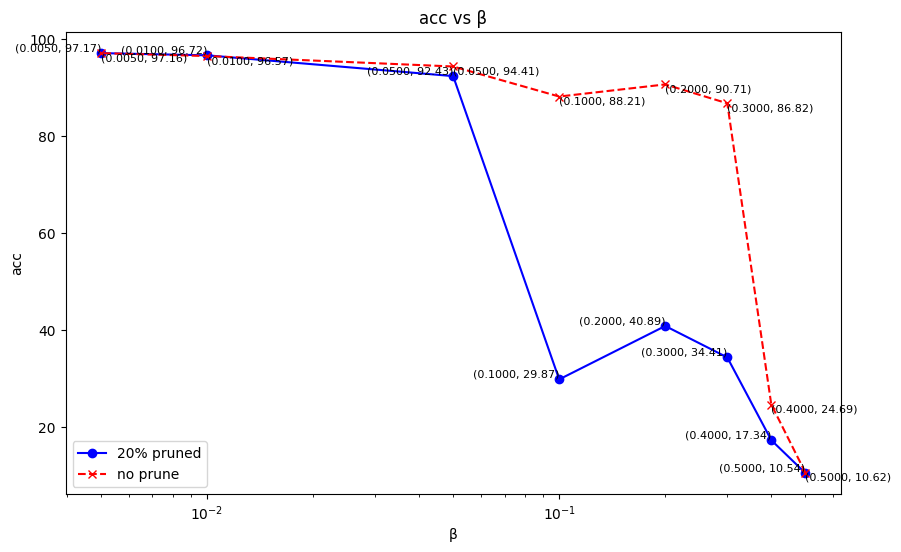

In [8]:
PRUNE_PERC = 0.2

pruned_acc_list = []
for b in tqdm(betas):
    model = VIBLeNet(z_dim=z_dim).to(device)
    weights = load_weights(f'weights/vib_lenet_300_100_mnist_{b}.pth', verbose=False)
    model.load_state_dict(weights)
    original_model = copy.deepcopy(model)

    pruned_model = copy.deepcopy(original_model)
    for layer_name in layer_names:
        module = dict(pruned_model.named_modules())[layer_name]
        prune.l1_unstructured(module, name='weight', amount=PRUNE_PERC)
        
    test_loss, test_acc = evaluate(pruned_model, test_loader, device, beta=b)
    pruned_acc_list.append(test_acc)
    
fig, ax = plot_x_y(betas, pruned_acc_list, og_acc_list, 'β', 'acc', f'{PRUNE_PERC*100:.0f}% pruned', 'no prune', True, True)

8it [00:00, 330.18it/s]


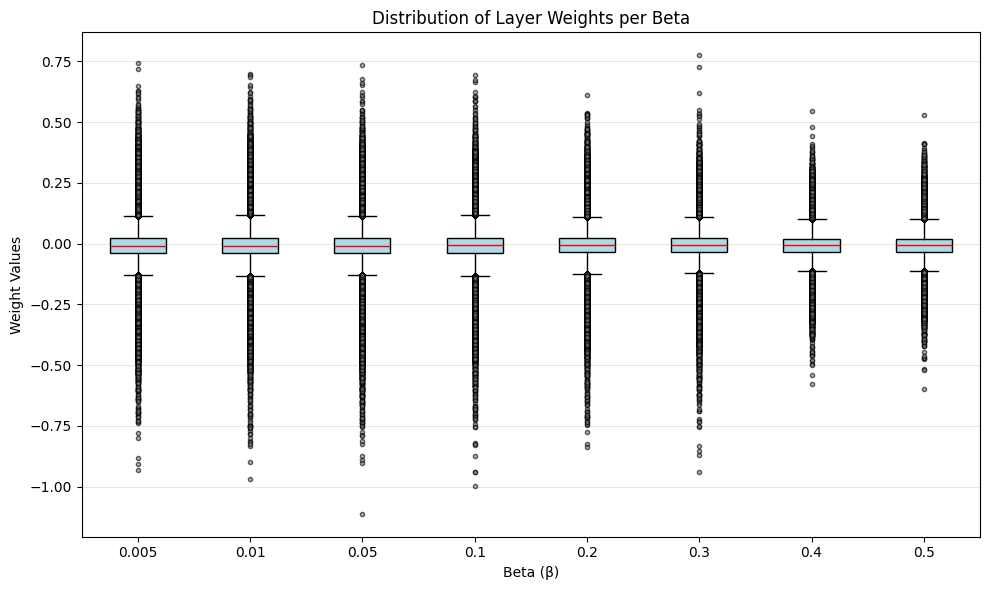

In [9]:
all_weights_by_beta = []
beta_labels = []
for b in tqdm(reversed(betas)):
    model = VIBLeNet(z_dim=z_dim)
    state = load_weights(f'weights/vib_lenet_300_100_mnist_{b}.pth', verbose=False)
    model.load_state_dict(state)

    weight_values = []
    for layer_name in layer_names:
        if layer_name == 'encoder.0' or layer_name == 'encoder.2':
        #if layer_name == 'fc_mu' or layer_name == 'fc_std':
            module = dict(model.named_modules()).get(layer_name)
            if module is not None and hasattr(module, 'weight') and module.weight is not None:
                weight_values.append(module.weight.data.flatten())

    beta_tensor = torch.cat(weight_values)
    all_weights_by_beta.append(beta_tensor.cpu().numpy())
    beta_labels.append(str(b))

plt.figure(figsize=(10, 6))

plt.boxplot(
    all_weights_by_beta,
    vert=True,
    patch_artist=True,
    boxprops=dict(facecolor='lightblue', color='black'),
    medianprops=dict(color='red'),
    whiskerprops=dict(color='black'),
    capprops=dict(color='black'),
    flierprops=dict(marker='o', markerfacecolor='gray', markersize=3, alpha=0.6)
)

plt.xticks(ticks=range(1, len(beta_labels) + 1), labels=beta_labels, rotation=0)
plt.xlabel('Beta (β)')
plt.ylabel('Weight Values')
plt.title('Distribution of Layer Weights per Beta')
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('plots/vib_lenet_300_100_mnist_dist_ib_layer_weights.png', dpi=300, bbox_inches='tight')
plt.show()